In [1]:
# Referred to https://github.com/scipy/scipy/blob/c1ed5ece8ffbf05356a22a8106affcd11bd3aee0/scipy/linalg/_sketches.py#L14
import numpy as np
from scipy._lib._util import check_random_state, rng_integers
from scipy.sparse import csc_matrix
import torch
import os
from fnmatch import fnmatch

#Read video in
import cv2
from matplotlib import pyplot as plt

In [2]:
rng = np.random.default_rng()

## Run follow cell to evaluate video through CW sketching matrix

In [3]:
# power method to calculate the leading singular vector/value
def PM(A,device,T=100, eps=1e-6):
    N = A.shape[1]
    v1 = torch.ones(N,device=device)/np.sqrt(N)
    B = A.T @ A
    for itr in range(T):
        v_prev = v1
        Bv1 = torch.matmul(B, v1)
        v1 = Bv1/torch.linalg.norm(Bv1)
        if torch.linalg.norm(v1-v_prev)/torch.linalg.norm(v_prev) < eps:
            break
    Av1 = torch.matmul(A, v1)
    e1 = torch.linalg.norm(Av1)
    u1 = Av1/e1
    return u1, v1, e1

# calculate svd using power method
def diff_SVD(A, m,device):
    U = []
    Vt = []
    E = []
    for j in range(m):
        u, v, e = PM(A,device)
        U.append(u)
        Vt.append(v)
        E.append(e)
        A = A - e*torch.outer(u, v)
    # seems we need to transpose to get the correct U
    U = torch.stack(U).T
    Vt = (torch.stack(Vt))
    E = torch.diag(torch.stack(E))
    return U, E, Vt

# main algorithm
def clarkson_woodruff(S, A, k,device):
    SA = torch.matmul(S, A)
    m = S.shape[0]
    U, E, Vt = diff_SVD(SA, m,device)
    V = Vt.T
    U2, E2, Vt2 = diff_SVD(torch.matmul(A, V),k,device)
    return U2@E2@Vt2@Vt

def cwt_matrix(n_rows, n_columns, seed=None):
    r"""
    Generate a matrix S which represents a Clarkson-Woodruff transform.
    Given the desired size of matrix, the method returns a matrix S of size
    (n_rows, n_columns) where each column has all the entries set to 0
    except for one position which has been randomly set to +1 or -1 with
    equal probability.
    Parameters
    ----------
    n_rows : int
        Number of rows of S
    n_columns : int
        Number of columns of S
    seed : {None, int, `numpy.random.Generator`, `numpy.random.RandomState`}, optional
        If `seed` is None (or `np.random`), the `numpy.random.RandomState`
        singleton is used.
        If `seed` is an int, a new ``RandomState`` instance is used,
        seeded with `seed`.
        If `seed` is already a ``Generator`` or ``RandomState`` instance then
        that instance is used.
    Returns
    -------
    S : (n_rows, n_columns) csc_matrix
        The returned matrix has ``n_columns`` nonzero entries.
    Notes
    -----
    Given a matrix A, with probability at least 9/10,
    .. math:: \|SA\| = (1 \pm \epsilon)\|A\|
    Where the error epsilon is related to the size of S.
    """
    rng = check_random_state(seed)
    rows = rng_integers(rng, 0, n_rows, n_columns)
    #Every column has exactly one non-zero element
    cols = np.arange(n_columns+1)
    signs = rng.choice([1, -1], n_columns)
    #signs=data, and data[cols[i]:cols[i+1]]=non-zero element value 
    #rows[cols[i]:cols[i+1]]=row index of non-zero elements
    #cols[i+1]-col[i]=number of non-zero elements in col i
    S = csc_matrix((signs, rows, cols),shape=(n_rows, n_columns))
    return S

def approx_A(A,S,device,m=10,k=10,method="CW"):
    r"""
    Return an approximate matrix of A based on the given parameters.
    Parameters
    ----------
    A : array
        The matrix to be approximated.
    m : int
        The number of rows of the sketching matrix S, which will be calculated in this function
    k : int
        The best-k approximation of A
    method : str
        The method used to generate the sketching matrix S, which can be "CW", "Gaussian"
        or "Train"
    seed : {None, int, `numpy.random.Generator`, `numpy.random.RandomState`}, optional
    Returns
    -------
    S : (n_rows, n_columns) csc_matrix
        The returned matrix has ``n_columns`` nonzero entries.
    A_approx: array
        The best-k approximation of A, shape = A.shape
    """
    if method=="CW":
        S = torch.from_numpy(S).float().to(device)
        A_approx = clarkson_woodruff(S,A,k,device)
        return A_approx
    elif method=="Gaussian":
        S = torch.from_numpy(S).float().to(device)
        A_approx = clarkson_woodruff(S,A,k,device)
        return A_approx
    elif method=="Train":
        S = S.to(device)
        A_approx = clarkson_woodruff(S,A,k,device)
        return A_approx
    return None

def eval_metric(A,A_approx,device,k=10):
    r"""
    Return an metric used in the paper.
    Parameters
    ----------
    A : array (height, width,number of frames)
        The matrix to be approximated.
    A_approx : array (height, width, number of frames)
        The best-k approximation of A, shape = A.shape
    k : int
        The best-k approximation of A
    Returns
    -------
    Error : float
        The error between A and A_approx. Formula follows section 5 in the paper.
    """
    #Best k approximation of A by only using SVD
    A_approx_svd = torch.zeros(A.shape,device=device)
    for i in range(A.shape[2]):
        U,E,Vt = diff_SVD(A[:,:,i],k,device)
        A_approx_svd[:,:,i] = U @ E @ Vt
    #Error
    Appte = A - A_approx_svd
    Appt = torch.mean(torch.norm(Appte,p=2,dim=(0,1)))
    error = A - A_approx
    error = torch.mean(torch.norm(error,p=2,dim=(0,1))) - Appt
    return error


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cap = cv2.VideoCapture('Dataset/MIT.mp4')
frame_number = 400
iter_number = 50
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
ret,A = cap.read()
A = np.reshape(A, (A.shape[0]*3, A.shape[1]))
n_row = A.shape[0]
k = 10
m = 10
mit_error_lst = []
S = []
S.append(torch.load("../m10-k10-z1-mit-sketch.pt"))
method = ["Train"]
for j in np.arange(len(S)):
    S_j = S[j]
    method_j = method[j]
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
    error_m = []
    for i in range(iter_number):
        print(i)
        ret, A = cap.read()
        if ret:
            A = A.astype(np.float32) / 255.0
            A = np.reshape(A, (A.shape[0]*3, A.shape[1]))
            A = torch.from_numpy(A).to(device)
            A_approx = approx_A(A,S_j,device,m=m,k=k,method=method_j)
            A_approx[A_approx>1] = 1
            A_approx[A_approx<0] = 0
            A = torch.unsqueeze(A,axis=2)
            A_approx = torch.unsqueeze(A_approx,axis=2)
            error = eval_metric(A,A_approx,device,k=10)
            error_m.append(error)
        else:
            break
    error_m = torch.stack(error_m)
    mit_error_lst.append(error_m.mean())
cap.release()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


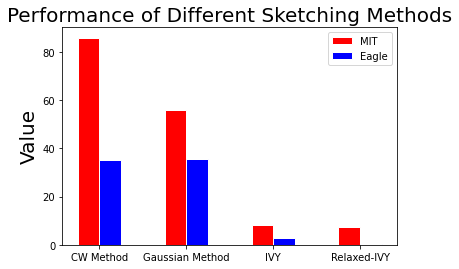

In [21]:
# data
section_labels = ['CW Method', 'Gaussian Method', 'IVY', 'Relaxed-IVY']
bar_labels = ['MIT', 'Eagle']
bar_values = np.abs(error_lst_z5.T)

# set width of bars
bar_width = 0.25

# set position of bars on x-axis
r1 = range(len(section_labels))
r2 = [x + bar_width for x in r1]

# create plot
plt.bar(r1, bar_values[0], color='r', width=bar_width, edgecolor='white', label=bar_labels[0])
plt.bar(r2, bar_values[1], color='b', width=bar_width, edgecolor='white', label=bar_labels[1])

# add xticks and labels
plt.xticks([r + bar_width/2 for r in range(len(section_labels))], section_labels,fontsize=10)

# add y-axis label
plt.ylabel('Value',fontsize=20)

# add legend
plt.legend()

# show plot
plt.title("Performance of Different Sketching Methods",fontsize=20)
plt.show()

In [5]:
#directory = "/path/to/directory"
directory = "../"
pattern = "40-*m*-k10-z5-mit-sketch.pt"
file_list = []

for path, subdirs, files in os.walk(directory):
    for name in files:
        if fnmatch(name, pattern):
            file_list.append(os.path.join(path, name))
print(file_list)

['../40-m10-k10-z5-mit-sketch.pt', '../40-m20-k10-z5-mit-sketch.pt', '../40-m30-k10-z5-mit-sketch.pt']


In [7]:
#m10-k10-z1-mit-sketch.pt
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cap = cv2.VideoCapture('Dataset/MIT.mp4')
frame_number = 400
iter_number = 40
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number-2)
ret,A = cap.read()
A = np.reshape(A, (A.shape[0]*3, A.shape[1]))
n_row = A.shape[0]
k = 10
m_lst = [10]
error_lst = []
cap.release()
S = torch.load('../40-m20-k10-z1-mit-sketch.pt')
for j in np.arange(1):
    m = m_lst[j]
    cap = cv2.VideoCapture('Dataset/MIT.mp4')
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
    error_tmp = []
    for i in range(iter_number):
        print(i)
        ret, A = cap.read()
        if ret:
            A = A.astype(np.float32) / 255.0
            A = np.reshape(A, (A.shape[0]*3, A.shape[1]))
            A = torch.from_numpy(A).to(device)
            A_approx = approx_A(A,S,device,m=m,k=k,method="Train")
            A_approx[A_approx>1] = 1
            A_approx[A_approx<0] = 0
            A = torch.unsqueeze(A,axis=2)
            A_approx = torch.unsqueeze(A_approx,axis=2)
            error = eval_metric(A,A_approx,device,k=10)
            error_tmp.append(error)
        else:
            break
    mean_tmp = torch.stack(error_tmp).mean().cpu().detach().numpy()
    print(mean_tmp)
    error_lst.append(mean_tmp)
    torch.cuda.empty_cache()
    cap.release()

error_lst = np.stack(error_lst)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0.40510234


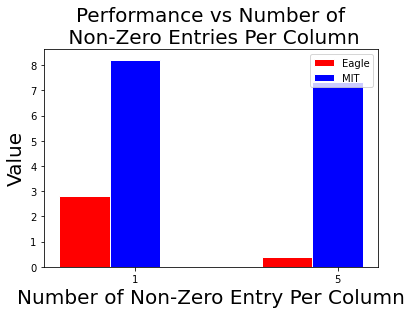

In [19]:
# data
section_labels = ["1","5"]
bar_labels = ['Eagle', 'MIT']
bar_values = np.abs(error_lst.T)

# set width of bars
bar_width = 0.25

# set position of bars on x-axis
r1 = range(len(section_labels))
r2 = [x + bar_width for x in r1]

# create plot
plt.bar(r1, bar_values[0], color='r', width=bar_width, edgecolor='white', label=bar_labels[0])
plt.bar(r2, bar_values[1], color='b', width=bar_width, edgecolor='white', label=bar_labels[1])

# add xticks and labels
plt.xticks([r + bar_width for r in range(len(section_labels))], section_labels,fontsize=10)
plt.xlabel('Number of Non-Zero Entry Per Column',fontsize=20)
# add y-axis label
plt.ylabel('Value',fontsize=20)

# add legend
plt.legend(loc='upper right')

# show plot
plt.title("Performance vs Number of\n Non-Zero Entries Per Column",fontsize=20)
plt.show()

In [30]:
A_plot = []

In [5]:
device="cuda"
m = 10
k = 10
cap = cv2.VideoCapture('Dataset/MIT.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 399)
ret,A = cap.read()
cap.release()
A = A.astype(np.float32) / 255.0
A = np.reshape(A, (A.shape[0]*3, A.shape[1]))
n_row = A.shape[0]
#S = cwt_matrix(m, n_row, seed=rng).toarray()
#S = np.random.normal(size=(m,n_row))
S = torch.load("../40-m10-k10-z1-mit-sketch.pt")
A = torch.from_numpy(A).to(device)
A_approx = approx_A(A,S,device,m=m,k=k,method="Train")
A_approx[A_approx>1] = 1
A_approx[A_approx<0] = 0
print(A_approx.shape)

torch.Size([2160, 1280])


In [44]:
A_approx = A_approx.cpu().detach().numpy().reshape((720,1280,3))

In [45]:
A_RGB = np.zeros(A_approx.shape)
A_RGB[:,:,0] = A_approx[:,:,2]
A_RGB[:,:,1] = A_approx[:,:,1]
A_RGB[:,:,2] = A_approx[:,:,0]

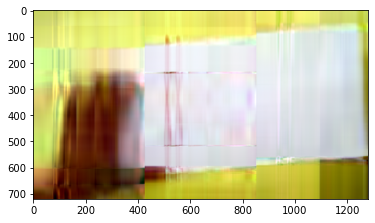

In [46]:
plt.imshow(A_RGB)

In [47]:
A_plot.append(A_RGB)

Text(0.5, 1.0, 'm=30, Relaxed-IVY')

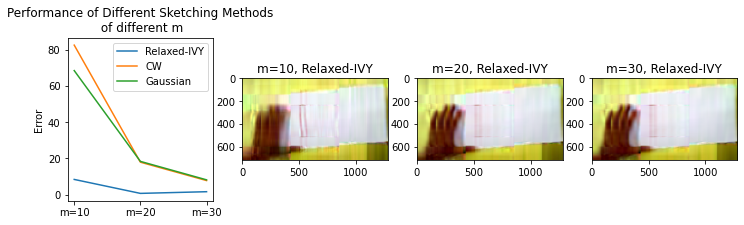

In [26]:
error_lst = np.array([[8.417897,0.728673,1.6548342],[82.41652,17.914549,7.7913513],[68.38968,18.358704,8.188838]])
fig,ax = plt.subplots(1,4,figsize=(12,3))
ax[0].plot(error_lst[0],label="IVY-Relaxed")
ax[0].plot(error_lst[1],label="CW")
ax[0].plot(error_lst[2],label="Gaussian")
ax[0].set_ylabel("Error")
# Set xticks as 1 and 5
ax[0].set_xticks([0,1,2],["m=10","m=20","m=30"])
ax[0].set_title("Performance of Different Sketching Methods\n of different m")
ax[0].legend(["Relaxed-IVY","CW","Gaussian"])
ax[1].imshow(A_plot[0])
ax[1].set_title("m=10, Relaxed-IVY")
ax[2].imshow(A_plot[1])
ax[2].set_title("m=20, Relaxed-IVY")
ax[3].imshow(A_plot[2])
ax[3].set_title("m=30, Relaxed-IVY")

Text(0.5, 1.0, 'Relaxed-IVY')

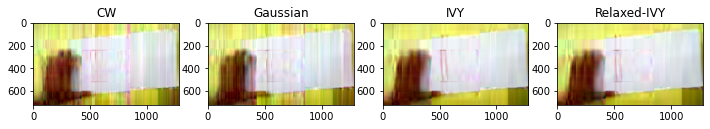

In [53]:
fig,ax = plt.subplots(1,4,figsize=(12,3))
ax[0].imshow(A_plot[0])
ax[0].set_title("CW")
ax[1].imshow(A_plot[1])
ax[1].set_title("Gaussian")
ax[2].imshow(A_plot[2])
ax[2].set_title("IVY")
ax[3].imshow(A_plot[3])
ax[3].set_title("Relaxed-IVY")